In [93]:
!pip install easyocr
!pip install opencv-python==4.5.4.60

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import cv2
import numpy as np
import os
import easyocr
from google.colab.patches import cv2_imshow

In [96]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/1_Orbit

/content/drive/MyDrive/1_Orbit


In [3]:
# settings 
input_width = 640
input_height = 640

In [4]:
# Load YOLO Model
net = cv2.dnn.readNetFromONNX('models/plate_detection.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [ ]:
import cv2
import numpy as np
import os
import easyocr

# settings 
input_width = 640
input_height = 640

# Load Model
net = cv2.dnn.readNetFromONNX('models/license_plate.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

def get_detections(img):
    # Convert Image to YOLO Format
    image = img.copy()
    row,col,d = image.shape

    max_rc = max(row, col)
    input_image = np.zeros((max_rc,max_rc, 3), dtype=np.uint8)
    input_image[0:row, 0:col] = image

    # Get Prediction From YOLO Model

    blob = cv2.dnn.blobFromImage(input_image,1/255,(input_width, input_height), swapRB=True, crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_suppression(input_image, detections):
    # Filter Detections Based on Confidence and Probability Score
    # centerx, center y, w, h, confidence, probability
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/input_width
    y_factor = image_h/input_height

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4]

        if confidence > 0.4: # Confidence of detecting license plate
            class_score = row[5] # Probability score of license plate
            if class_score > 0.25:
                cx, cy, w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy - 0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # Clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # Non Maximum Suppression
    index = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45)
    
    return boxes_np, confidences_np, index

def draw_bb(image, boxes_np, confidences_np, index, filename):
    # Draw Bounding Box
    for ind in index:
        x, y, w, h = boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text, bbox = extract_text(image, boxes_np[ind])
    
        cv2.rectangle(image, (x,y-40), (x+w+85,y), (254,0,0),-1) # Blue Box Containing Confidence Score     
        cv2.rectangle(image, (x,y+h), (x+w+85, y+h+30), (0,0,0), -1) # Black Box Containing OCR Result
        
        cv2.putText(image, conf_text, (x, y-15), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255,255,255), 1) # Confidence Score Text
        cv2.putText(image, license_text, (x, y+h+25), cv2.FONT_HERSHEY_DUPLEX, 0.8, (0,255,0), 1)# OCR Result
        cv2.rectangle(image, (x,y), (x+w,y+h), (0,80,255), 2) # Orange Box
        cv2.imwrite('static/predict/{}'.format(filename), image) # Save Image Prediction Result
        
        roi = image[y:y+h, x:x+w]
        cv2.imwrite('static/roi/{}'.format(filename), roi) # Save Image ROI Result
    
    return license_text

def extract_text(image, bbox):
    x, y, w, h = bbox
    roi = image[y:y+h, x:x+w]
    if 0 in roi.shape:
        return ''
    else:
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(roi)
        text = ''

        for i in ocr_result:
            text = text + " "+ i[1]

        text_result = ' '.join(text.split()).upper()
        return text_result, bbox

# Predictions
# Predictions
def yolo_predictions(img, filename):
    img = cv2.imread(img)
    ## Step-1: Detections
    input_image, detections = get_detections(img)
    ## Step-2: NMS
    boxes_np, confidences_np, index = non_maximum_suppression(input_image, detections)
    ## Step-3: Draw Bounding Box
    img_result = draw_bb(img, boxes_np, confidences_np, index, filename)
    
    return img_result

In [46]:
import cv2
import numpy as np
import os
import easyocr

# settings 
input_width = 640
input_height = 640

# Load Model
net = cv2.dnn.readNetFromONNX('model/license_plate_model.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

def get_detections(image):
    # Convert Image to YOLO Format
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row, col)
    input_image = np.zeros((max_rc,max_rc, 3), dtype=np.uint8)
    input_image[0:row, 0:col] = image

    # Get Prediction From YOLO Model

    blob = cv2.dnn.blobFromImage(input_image,1/255,(input_width, input_height), swapRB=True, crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_suppression(input_image, detections):
    # Filter Detections Based on Confidence and Probability Score
    # centerx, center y, w, h, confidence, probability
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/input_width
    y_factor = image_h/input_height

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4]

        if confidence > 0.4: # Confidence of detecting license plate
            class_score = row[5] # Probability score of license plate
            if class_score > 0.25:
                cx, cy, w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy - 0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # Clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # Non Maximum Suppression
    index = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45)
    
    return boxes_np, confidences_np, index

def draw_bb(image, boxes_np, confidences_np, index, filename):
    # Draw Bounding Box
    for idx in index:
        x, y, w, h = boxes_np[idx]
        bb_conf = confidences_np[idx]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text, bbox = extract_text(image, boxes_np[idx])
    
        cv2.rectangle(image, (x,y-40), (x+w+85,y), (254,0,0),-1) # Box Containing Confidence Score     
        cv2.rectangle(image, (x,y+h), (x+w+85, y+h+30), (0,0,0), -1) # Box Containing OCR Result
        
        cv2.putText(image, conf_text, (x, y-15), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255,255,255), 1) # Confidence Score Text
        cv2.putText(image, license_text, (x, y+h+25), cv2.FONT_HERSHEY_DUPLEX, 0.8, (0,255,0), 1) # OCR Result Text
        cv2.rectangle(image, (x,y), (x+w,y+h), (0,80,255), 2) # Bounding Box

        cv2.imwrite('static/predict/{}'.format(filename), image) # Save Image Prediction Result
        roi = image[y:y+h, x:x+w]
        cv2.imwrite('static/roi/{}'.format(filename), roi) # Save Image ROI Result
        roi_blur = roi.copy()
        cv2.imwrite('static/blurred_roi/{}'.format(filename), blur(roi_blur))

    return license_text

def extract_text(image, bbox):
    x, y, w, h = bbox
    roi = image[y:y+h, x:x+w]

    if 0 in roi.shape:
        return ''
    else:
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(roi)
        text = ''

        for i in ocr_result:
            text = text + " "+ i[1]

        text_result = ' '.join(text.split()).upper()
        return text_result, bbox

def blur(roi):
    blurred_image = cv2.blur(roi, (10,10)) 
    return blurred_image

# Predictions
def yolo_predictions(image_location, filename):
    image = cv2.imread(image_location)
    ## Step-1: Detections
    input_image, detections = get_detections(image)
    ## Step-2: NMS
    boxes_np, confidences_np, index = non_maximum_suppression(input_image, detections)
    ## Step-3: Draw Bounding Box
    img_result = draw_bb(img, boxes_np, confidences_np, index, filename)
    
    return img_result

In [40]:
def get_detections(img):
    # Convert Image to YOLO Format
    image = img.copy()
    row,col,d = image.shape

    max_rc = max(row, col)
    input_image = np.zeros((max_rc,max_rc, 3), dtype=np.uint8)
    input_image[0:row, 0:col] = image

    # Get Prediction From YOLO Model
    blob = cv2.dnn.blobFromImage(input_image,1/255,(input_width, input_height), swapRB=True, crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_suppression(input_image, detections):
    # Filter Detections Based on Confidence and Probability Score
    # centerx, center y, w, h, confidence, probability
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/input_width
    y_factor = image_h/input_height

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4]

        if confidence > 0.4: # Confidence of detecting license plate
            class_score = row[5] # Probability score of license plate
            if class_score > 0.25:
                cx, cy, w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy - 0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # Clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # Non Maximum Suppression
    index = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45)
    
    return boxes_np, confidences_np, index

def blur(x,y,h,w, img):
    blurred_image = img
    blurred_image[y:y+h, x:x+w] = cv2.blur(img[y:y+h, x:x+w] ,(100,100))
    return blurred_image

def draw_bb(image, boxes_np, confidences_np, index, filename):
    image_blur = image.copy()
    # Draw Bounding Box
    for ind in index:
        x, y, w, h= boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plat: {:.0f}%'.format(bb_conf*100)
        license_text, bbox = extract_text(image, boxes_np[ind])

        cv2.rectangle(image, (x,y-40), (x+w+85,y), (254,0,0),-1) # Blue Box Containing Confidence Score     
        cv2.rectangle(image, (x,y+h), (x+w+85, y+h+30), (0,0,0), -1) # Black Box Containing OCR Result
        
        cv2.putText(image, conf_text, (x, y-15), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255,255,255), 1) # Confidence Score Text
        cv2.putText(image, license_text, (x, y+h+25), cv2.FONT_HERSHEY_DUPLEX, 0.8, (0,255,0), 1)# OCR Result

        cv2.rectangle(image, (x,y), (x+w,y+h), (0,80,255), 2) # Bounding Box
        cv2.imwrite('static/predict/{}'.format(filename), image) # Save Image Prediction Result
        
        roi = img[y:y+h, x:x+w]
        roi_bgr = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
        cv2.imwrite('static/roi/{}'.format(filename), roi_bgr) # Save Image ROI Result

        image_blur = blur(x,y,h,w,image_blur)
        cv2.imwrite('static/blurred_image/{}'.format(filename), image_blur)
        roi_blur = image_blur[y:y+h, x:x+w]
        cv2.imwrite('static/blurred_roi/{}'.format(filename), roi_blur)

    return license_text, image, roi_bgr, roi_blur, image_blur

In [41]:
def extract_text(image, bbox):
    x, y, w, h = bbox
    roi = image[y:y+h, x:x+w]
    if 0 in roi.shape:
        return ''
    else:
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(roi)
        text = ''
        for i in ocr_result:
            text = text + " "+ i[1]
            
            print(i)
            
        text_result = ' '.join(text.split()).upper()
        return text_result, bbox

In [42]:
# Predictions
def yolo_predictions(img, filename):
    ## Step-1: Detections
    input_image, detections = get_detections(img)
    ## Step-2: NMS
    boxes_np, confidences_np, index = non_maximum_suppression(input_image, detections)
    ## Step-3: Draw Bounding Box
    img_result, img, roi, blur_roi, image_blur = draw_bb(img, boxes_np, confidences_np, index, filename)
    
    return img_result, img, roi, blur_roi, image_blur

In [37]:
# Load the Image
img = cv2.imread('./test_images/98e44942-7668-47e8-a1d8-f49eb1482222.jpg')

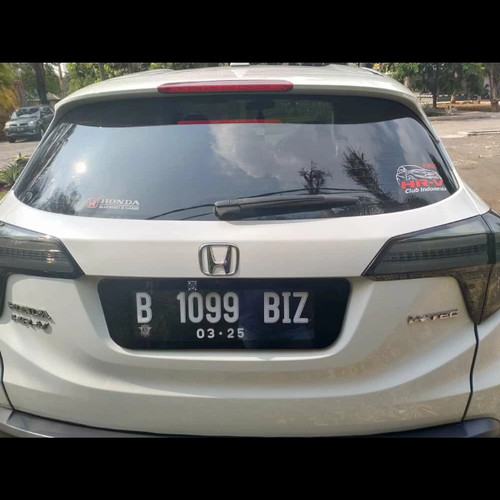

In [43]:
image = img.copy()
cv2_imshow(image)

In [44]:
# Test
results, img, roi, blur_roi, blur_img = yolo_predictions(image, 'image_2022-05-31_212415797.png')

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


([[0, 4], [24, 4], [24, 38], [0, 38]], 'B', 0.9991676156098492)
([[39, 0], [185, 0], [185, 43], [39, 43]], '1099   BIZ', 0.9303521951800171)
([[63, 39], [117, 39], [117, 55], [63, 55]], '03.25', 0.9794838951242418)


B 1099 BIZ 03.25


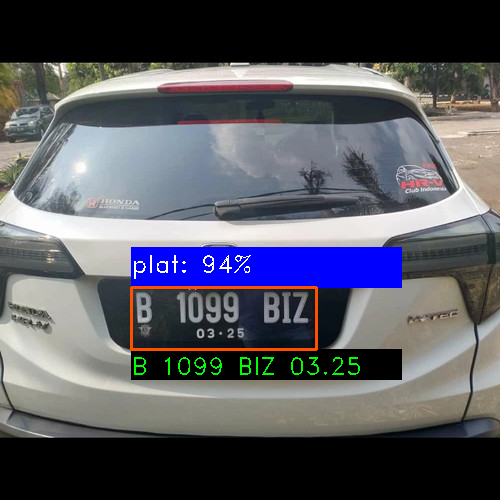

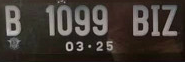

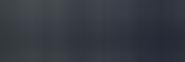

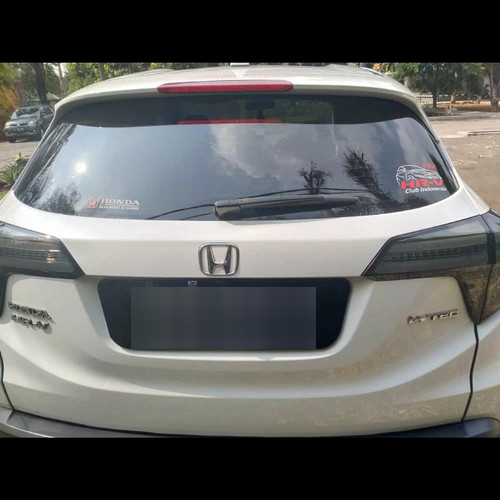

In [45]:
print(results)
cv2_imshow(img)
cv2_imshow(roi)
cv2_imshow(blur_roi)
cv2_imshow(blur_img)

In [ ]:
import math
from typing import Tuple, Union

import cv2
import numpy as np

from deskew import determine_skew


def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

grayscale = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
angle = determine_skew(grayscale)
rotated = rotate(test, angle, (0, 0, 0))
cv2.imwrite('output.png', rotated)

True

In [ ]:
test = cv2.imread('./test_images/337.E 3955 PAK-02-22.jpeg')

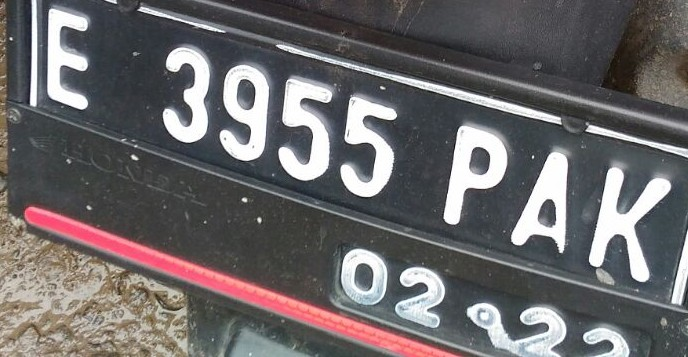

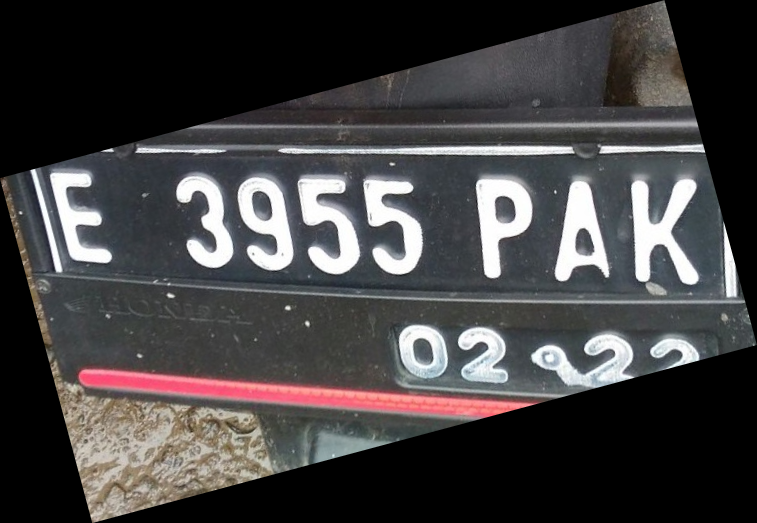

In [ ]:
cv2_imshow(test)
cv2_imshow(rotated)

In [ ]:
asd = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [ ]:
print('rotated')
for i in asd.readtext(rotated):
    print(i)
print('raw')
for idx in asd.readtext(test):
    print(idx)

rotated
([[31, 167], [117, 167], [117, 269], [31, 269]], 'IE', 0.991764442925113)
([[165, 161], [715, 161], [715, 298], [165, 298]], '3955 PAk', 0.8004843510011681)
([[392, 316], [693, 316], [693, 394], [392, 394]], '02 993', 0.7393331173064123)
raw
([[22, 10], [100, 10], [100, 112], [22, 112]], 'IE', 0.36334651176904686)
([[170.16331580223996, 18.0233528600952], [432.88984452248985, 103.18546697575393], [387.83668419776006, 226.9766471399048], [124.11015547751018, 140.81453302424606]], '3955', 0.9999989867210388)
([[460.09748443378584, 97.02547447800902], [705.8076169501857, 178.52628895054346], [657.9025155662142, 305.974525521991], [412.19238304981434, 224.47371104945654]], 'Pak', 0.3621259538611357)
([[345.0242857596863, 228.0477147488002], [477.6554960993104, 267.397809561888], [449.9757142403137, 349.9522852511998], [317.3445039006896, 310.602190438112]], '02', 0.9997366766461455)
([[470.18211126702823, 281.04794576973984], [638.9375277464516, 318.06688223293344], [622.8178887329

Best angle: -1


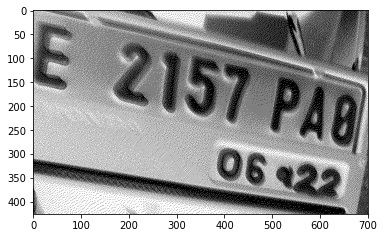

In [ ]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import interpolation as inter
input_file = ('./test_images/219.E 6312 SW-07-21.jpeg')

img = im.open(input_file)
# convert to binary
wd, ht = img.size
pix = np.array(img.convert('1').getdata(), np.uint8)
bin_img = 1 - (pix.reshape((ht, wd)) / 255.0)
plt.imshow(bin_img, cmap='gray')
plt.savefig('binary.png')
def find_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score
delta = 1
limit = 5
angles = np.arange(-limit, limit+delta, delta)
scores = []
for angle in angles:
    hist, score = find_score(bin_img, angle)
    scores.append(score)
best_score = max(scores)
best_angle = angles[scores.index(best_score)]
print('Best angle: {}'.format(best_angle))
# correct skew
data = inter.rotate(bin_img, best_angle, reshape=False, order=0)
img = im.fromarray((255 * data).astype("uint8")).convert("RGB")
img.save('skew_corrected.png')

# Real Time Object Detection

In [ ]:
### Real Time Object Detection
cap = cv2.VideoCapture('./test_images/video_2022-05-31_16-55-34.mp4')

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)
result = cv2.VideoWriter('test.mp4', 
                         cv2.VideoWriter_fourcc(*'MP4V'),
                         10, size)
while True:
    ret,frame = cap.read()
    if ret == False:
        print('unable to read video')
        break
    
    results = yolo_predictions(frame, net)
    result.write(results)
    cv2.namedWindow('YOLO', cv2.WINDOW_KEEPRATIO)
    cv2.imshow('YOLO Prediction', results)
    if cv2.waitKey(1) == 27:
        break
        
cv2.destroyAllWindows()
cap.release()
result.release()

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

unable to read video
